# Part 1: Understanding Convlutions

## Step 0: Some import and later required functions

In [86]:
# Imports
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

In [94]:
# Some Plotting Functions

def show_grating(img, ax=None, show=False):
  """Visualize a grating"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_weights(weights, channels=[0]):
  """ plot convolutional channel weights
  Args:
      weights: weights of convolutional filters (conv_channels x K x K)
      channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1, len(channels), figsize=(12, 2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel, 0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title(f'channel {channel}')

    cb_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=cb_ax)
    cb_ax.axis('off')
  plt.show()


def plot_example_activations(grating, act, channels=[0]):
  """ plot activations act and corresponding grating
  Args:
    grating: image input to convolutional layer (n x h x w) or (h x w)
    act: activations of convolutional layer (n_bins x conv_channels x n_bins)
    channels: which conv channels to plot
  """
  if grating.ndim>2:
    n_grating = grating.shape[0]
  else:
    grating = grating.unsqueeze(0)
    n_grating = 1

  fig, axs = plt.subplots(n_grating, 1 + len(channels), figsize=(12, 12))

  # plot grating
  for i in range(n_grating):
    show_grating(grating[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('grating')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      im = ax.imshow(act[i, channel], vmin=-3, vmax=3, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title(f'channel {channel}')

    cb_ax = fig.add_axes([1.05, 0.8, 0.01, 0.1])
    plt.colorbar(im, cax=cb_ax)
    cb_ax.set_title('activation\n strength')
  plt.show()

In [95]:
def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating 

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

## Step 1: Image Processing

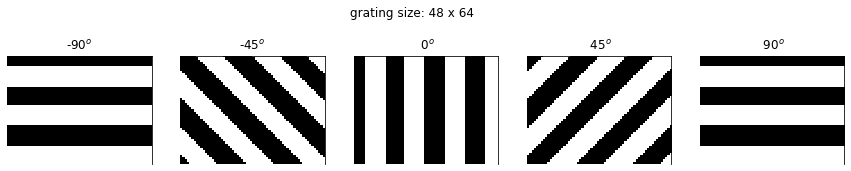

In [96]:
#Execute this cell to plot example grating

orientations = np.linspace(-90, 90, 5) # You can play with the orientations

h_ = 3
n_col = len(orientations)
h, w  = grating(0).shape  # height and width of grating

fig, axs = plt.subplots(1, n_col, figsize=(h_ * n_col, h_))
for i, ori in enumerate(orientations):
  grat = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_grating(grat, axs[i])
fig.suptitle(f'grating size: {h} x {w}')
plt.show()

Let's implement 2D convolutional operations. We will use multiple convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv2d()`, which requires the following arguments for initialization (see full documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)):
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters

When you run the network, you can input an image of arbitrary size $(H^{in}, W^{in})$, but it needs to be shaped as a 4D input $(N, C^{in}, H^{in}, W^{in})$, where $N$ is the number of samples. In our case, $C^{in}=1$ because there is only one color channel (our images are grayscale, but often $C^{in}=3$ in image processing).

In [97]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=2, K=3, filters=None):
    """Initialize layer

    Args:
        c_in: number of input image channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run convolutional layer on images

    Args:
        s (torch.Tensor): n_samples x c_in x h x w tensor of the images

    Returns:
        (torch.Tensor): n_samples x c_out x h x w tensor with convolutional layer unit activations.

    """
    a = self.conv(s)  # output of convolutional layer

    return a

See that `ConvolutionalLayer` takes as input `filters`. We have predesigned some filters that you can use by calling the `filters` function below. These are similar to filters we think are implemented in biological circuits such as the retina and the visual cortex. In general, these filters will be learned in training based on the down-stream task.



In [98]:
def _filters(out_channels=2):
    """ Create example filters for vertical and horizontal edge detection.
    Returns:
        filters: out_channels x 1 x K x K (torch tensor)
    """
    # Initialize filters array
    filters = np.zeros((2, 3, 3), dtype=np.float32)

    # Vertical edge filter
    filters[0, :, :] = np.array([[1, 0, -1],
                                 [1, 0, -1],
                                 [1, 0, -1]])

    # Horizontal edge filter
    filters[1, :, :] = np.array([[1, 1, 1],
                                 [0, 0, 0],
                                 [-1, -1, -1]])

    # Normalize to range [-1, 1] to maintain consistent intensity
    filters /= np.abs(filters).max()

    # Convert to torch tensor
    filters = torch.from_numpy(filters)

    # Add channel dimension (1 in channel)
    filters = filters.unsqueeze(1)

    return filters

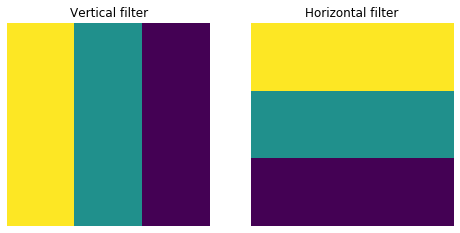

In [99]:
example_filters = _filters(out_channels=2) #torch.Size([2, 1, 3, 3])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_filters[0,0], vmin=-1, vmax=1, cmap = 'grey')
plt.title('Vertical filter')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(example_filters[1,0], vmin=-1, vmax=1, cmap = 'grey')
plt.title('Horizontal filter')
plt.axis('off')
plt.show()

### Coding Exercise 1: 2D convolution in PyTorch

We will now run the convolutional layer on our grating. We will use gratings made using the function `grating`, which returns a iamge which is 48 x 64.

Reminder, `nn.Conv2d` takes in a tensor of size $(N, C^{in}, H^{in}, W^{in}$) where $N$ is the number of samples, $C^{in}$ is the number of input channels, and $(H^{in}, W^{in})$ is the size of the grating. We will need to add these first two dimensions to our samples, then input it to the convolutional layer.

We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in}, W^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. It is the same size as the input because we used a stride of 1 and padding that is half the kernel size.


/Users/Psychology/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


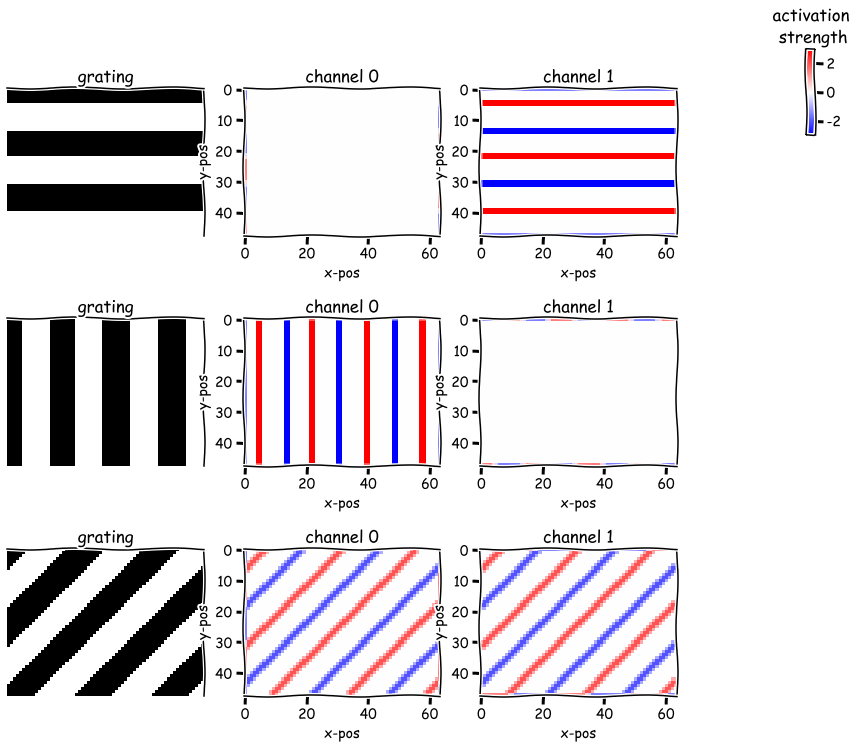

In [110]:
# Grating image parameters
in_channels = 1  # how many input channels in our images
h = 48  # height of images
w = 64  # width of images

# Convolution layer parameters
K = 2  # filter size 
out_channels = 2  # how many convolutional channels to have in our layer
example_filters = _filters(out_channels)  # create filters to use

convout = np.zeros(0)  # initizalize convolutional activations to convout

# TODO: Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(..., filters=example_filters)

# Create grating image (H_in, W_in)
orientations = [90, 0, 45]
grats = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)
for i,ori in enumerate(orientations):
  grats[i, 0] = grating(ori, sf=1 / 28, res=0.1)

#TODO: apply the convLayer to the grating data 
convout = convLayer(...)
convout = convout.detach()  # detach gradients

with plt.xkcd():
  plot_example_activations(grats, convout, channels=np.arange(0, out_channels))

Let's think about why the activations look the way they do:
The vertical edge filter is designed with weights that amplify changes in pixel intensity that occur from left to right across an image. The filter consists of positive weights on one side and negative weights on the other, creating a high response when there is a clear, vertical transition in pixel brightness. This makes the filter sensitive to vertical lines where there's a strong contrast, such as from white to black or black to white.
The sign of the activation depends on the direction of the luminance gradient. If the transition is from light (white) to dark (black) from left to right, the activation will be positive. Conversely, if the transition is from dark to light from left to right, the activation will be negative. This property allows the filter to not only detect the presence of a vertical edge but also infer the direction of the edge gradient.

# Part 2

## Step 0: install the dataset

The "Hello World" of convolutional neural networks are MNIST images. You can get the training data by running the following command in pip

In [115]:
!pip install mnist

## Step 1: Data Preparation in PyTorch

The MNIST dataset is a collection of handwritten digits commonly used for training and testing in the field of machine learning. We want to normalize data and create randomized batches for training and evaluation. It consists of 60,000 images for training and 10,000 images for testing. Each image is 28*28 pixels.


In [118]:
import mnist

# Load the labels for the training and test datasets.
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()

# Calculate the mean and standard deviation of the training images.
scale_mean, scale_std = mnist.train_images().mean(), mnist.train_images().std()

# Standardize the training and test images by subtracting the mean and dividing by the standard deviation.
train_images = (mnist.train_images() - scale_mean) / scale_std
test_images = (mnist.test_images() - scale_mean) / scale_std

In [119]:
def make_batch(N=300, collection='train'):
    # Select the correct sub-dataset based on the 'collection' flag.
    images = train_images if collection == 'train' else test_images
    labels = train_labels if collection == 'train' else test_labels
    
    # Randomly sample N indices from the image dataset.
    indices = np.random.choice(np.arange(len(images)), size=(N,), replace=True)
    
    # Gather the images and labels corresponding to the sampled indices.
    X = images[indices]
    y = labels[indices]
    
    # Convert the sampled image data and labels into PyTorch tensors.
    return torch.FloatTensor(X[:, None]), torch.LongTensor(y)


## Step 2: Building a Convolutional Neural Network with PyTorch

In this part of the tutorial, we will create a simple Convolutional Neural Network (CNN) using PyTorch's modular `nn` library. 

### Tasks

#### 1. Construct the CNN
Define a CNN according to the following specifications:
- **First Layer**: A convolutional layer with a 5x5 kernel that expands the input from 1 channel to 16 channels, followed by a ReLU activation function, and a 2x2 max-pooling layer.
- **Second Layer**: A convolutional layer with a 3x3 kernel keeping the channel size at 16, followed by a ReLU activation function, and another 2x2 max-pooling layer.
- **Third Layer**: A convolutional layer with a 2x2 kernel that increases the channel size from 16 to 32. This layer is followed by a ReLU but does not have a pooling layer.

#### 2. Analyze Dimensions
Create a random MNIST-like input tensor `x` with dimensions (bs, 1, 28, 28) where bs is the batch size:
```python
x = torch.randn(bs, 1, 28, 28)
```
Feed this tensor through your network and print the output dimensions after each layer. This will help you understand how image dimensions change as they pass through convolutions and pooling layers.

#### 3. Flatten the Output
Use `torch.nn.Flatten` to flatten the output from the last convolutional layer into a single vector per image in the batch. Document the size of this flattened vector. This size is critical as it will determine the input dimension of your final fully connected layer.

#### 4. Complete the Network with a Classification Head
Finish your network by adding a fully connected layer that maps the flattened output to 10 classes (representing the digits 0 through 9). Assume the output from the flatten operation is `N`:
```python
nn.Linear(N, 10)
```
This layer will serve as the head of your network that predicts the class probabilities.


### Hints
- Use the PyTorch documentation to ensure your layer parameters are set correctly.
- Be mindful of the batch size when interpreting the dimensions of outputs throughout the network.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        # TODO: Define first convolutional layer with 16 filters of size 5x5.
        self.conv1 = None
        # TODO: Define the second convolutional layer
        self.conv2 = None
        # TODO: Define the third convolutional layer
        self.conv3 = None
        
        # TODO: Define a max pooling layer with a 2x2 window
        self.pool = None
        
        # TODO: Calculate the correct number of features to input to this layer from the output of the last Conv layer
        self.fc = nn.Linear(None, 10)  # TODO: Change None to the correct number of input features

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolutional layer followed by ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Apply the third convolutional layer
        x = F.relu(self.conv3(x))
        
        # Flatten the output from the convolutional layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        # Apply the fully connected layer
        x = self.fc(x)
        
        return x

## Step 3: Implementing a Training Loop in PyTorch on MNIST

### Objective
You will complete the implementation of a basic training loop for a neural network model using PyTorch.

### Tasks

1. **Set Up the Optimizer**
   - Initialize the Adam optimizer with a learning rate of 0.001. Use `model.parameters()` to specify which parameters the optimizer should update.

2. **Forward Pass**
   - Perform the forward pass by passing the input batch `X` through the model. Assign the output to `p`.

3. **Loss Computation**
   - Calculate the loss using the cross-entropy loss function, which is appropriate for classification tasks. PyTorch's `torch.nn.functional.cross_entropy` can be used here, which internally applies a softmax on the model's outputs.

4. **Backpropagation**
   - Use the `.backward()` method on the `loss` variable to compute gradients for the parameters.

5. **Clear Gradients**
   - After updating the model parameters, clear the optimizer's gradients with the appropriate method to prevent them from accumulating.



In [1]:
def train(model, itrs=500):
    # Initialize a list to store loss values at each step to visualize the training progress.
    loss_val = []
    
    # TODO: Set up the optimizer; using Adam with a learning rate of 0.001, and model.parameters()
    optim = None
    
    # Start the training loop for a specified number of steps.
    for i in range(itrs):
        # Sample a batch of data; 'make_batch' should provide input features X and labels y.
        X, y = make_batch(N=200, collection='train')
        
        # TODO: Forward pass, compute the model's predictions based on the input batch.
        p = None
        
        # TODO: Compute the loss using PyTorch cross-entropy, this evaluates the multi-class loss (the softmax is done internally)
        loss = None
        
        # TODO: Perform backpropagation on loss to calculate gradients.
        ###HERE###
        # Update model parameters based on computed gradients.
        optim.step()
        
        # TODO: Clear the gradients of the optimizer to prevent them from accumulating.
        ###HERE###
        # Store the current loss value to track how it changes through training.
        loss_val.append(float(loss))
        
        # Every 100 steps, print the current step number and its corresponding loss.
        if i % 100 == 0:
            print(f'loss: {i}: {loss:.4f}')
    
    # Return the trained model and the trajectory of loss values.
    return model, np.array(loss_val)


In [137]:
model = MyCNN()
trained_model, ls_val = train(model)

loss: 0: 2.3038


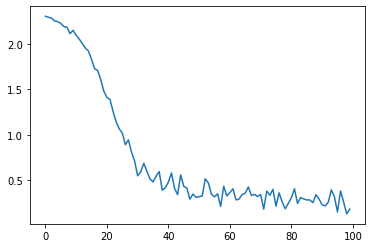

In [138]:
plt.plot(las_val)

## Step 4 - evaluate on the test set

### Objective
Now that you have trained your model, it's crucial to evaluate its performance on test data.



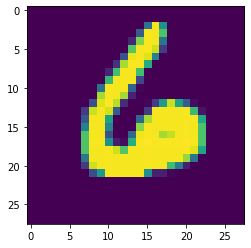

In [139]:
X,y = make_batch(N = 1, collection='test')
plt.imshow(X[0,0])

/Users/Psychology/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


[]

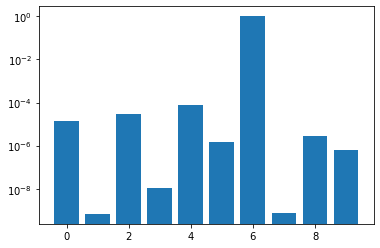

In [ ]:
# Plot a bar chart of class probabilities for a single sample from model output
# `torch.nn.functional.softmax(...)`: Apply the softmax function to convert logits into probabilities.
plt.bar(range(10), torch.nn.functional.softmax(model(X)).detach()[0])

plt.semilogy()
